In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

HIST_IN = "historical_data.csv"        
FG_IN   = "fear_greed_index.csv"


orig = pd.read_csv(HIST_IN, low_memory=False)
fg   = pd.read_csv(FG_IN, low_memory=False)
orig.columns = [c.strip() for c in orig.columns]

if 'Timestamp' in orig.columns:
    orig['time_from_ts'] = pd.to_datetime(orig['Timestamp'], unit='ms', errors='coerce')
if 'Timestamp IST' in orig.columns:
    orig['time_from_ist'] = pd.to_datetime(orig['Timestamp IST'], dayfirst=True, errors='coerce')

orig['time_parsed'] = orig.get('time_from_ist').where(orig.get('time_from_ist').notna(), orig.get('time_from_ts'))
print("Number of rows with missing parsed time:", orig['time_parsed'].isna().sum())
pnl_col = next((c for c in orig.columns if 'closed' in c.lower() and 'pnl' in c.lower()), None)
orig['closed_pnl'] = pd.to_numeric(orig[pnl_col], errors='coerce')
orig['trade_date'] = pd.to_datetime(orig['time_parsed']).dt.date
fg['date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date

if 'value' in fg.columns: fg = fg.rename(columns={'value':'fg_score'})
if 'classification' in fg.columns: fg = fg.rename(columns={'classification':'fg_label'})


merged = orig.merge(fg[['date','fg_score','fg_label']], left_on='trade_date', right_on='date', how='left')
merged['profit_binary'] = (merged['closed_pnl'] > 0).astype(int)

if 'Size USD' in merged.columns:
    merged['size_usd'] = pd.to_numeric(merged['Size USD'], errors='coerce')
if 'leverage' in merged.columns:
    merged['leverage'] = pd.to_numeric(merged['leverage'], errors='coerce')


acct_col = next((c for c in merged.columns if c.lower()=='account'), 'Account' if 'Account' in merged.columns else None)
if acct_col is None:
    merged['account'] = 'unknown'; acct_col = 'account'

trader_summary = merged.groupby(acct_col).agg(
    n_trades = ('closed_pnl','count'),
    total_pnl = ('closed_pnl','sum'),
    avg_pnl = ('closed_pnl','mean'),
    win_rate = ('closed_pnl', lambda x: (x>0).mean())
).reset_index().sort_values('total_pnl', ascending=False)

trader_summary.to_csv('trader_summary.csv', index=False)
merged.to_csv('historical_merged_v2.csv', index=False)


daily = merged.groupby('trade_date').agg(
    daily_pnl=('closed_pnl','sum'),
    n_trades=('closed_pnl','count'),
    avg_pnl=('closed_pnl','mean'),
    fg_score=('fg_score','first'),
    fg_label=('fg_label','first')
).reset_index()
daily.to_csv('daily_agg.csv', index=False)


label_stats = merged.groupby('fg_label').agg(
    n_trades=('closed_pnl','count'),
    mean_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    win_rate=('closed_pnl', lambda x: (x>0).mean())
).reset_index().sort_values('n_trades', ascending=False)
label_stats.to_csv('label_stats_v2.csv', index=False)

groups = [merged.loc[merged['fg_label']==lbl, 'closed_pnl'].dropna().values for lbl in merged['fg_label'].dropna().unique()]
if len(groups) >= 2:
    h, p = kruskal(*groups)
    print("Kruskal-Wallis H", h, "p", p)

model_df = merged.copy()
model_df['fg_score'] = pd.to_numeric(model_df.get('fg_score'), errors='coerce')
model_df['size_usd'] = pd.to_numeric(model_df.get('size_usd'), errors='coerce')
if 'Side' in model_df.columns:
    model_df['side_enc'] = model_df['Side'].astype(str).str.lower().map(lambda s: 1 if 'buy' in s or 'long' in s else 0)
else:
    model_df['side_enc'] = np.nan

features = ['fg_score','size_usd','side_enc']
model_df = model_df.dropna(subset=features + ['closed_pnl'])
model_df['profit_binary'] = (model_df['closed_pnl']>0).astype(int)

if len(model_df) >= 200:
    X = model_df[features].fillna(0)
    y = model_df['profit_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    joblib.dump(clf, 'rf_profit_model_v2.joblib')
    print("RF AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
else:
    print("Not enough rows to train model after filtering:", len(model_df))

Number of rows with missing parsed time: 0
Kruskal-Wallis H 1226.9955994737047 p 2.2377483557731266e-264
RF AUC: 0.811477698648621


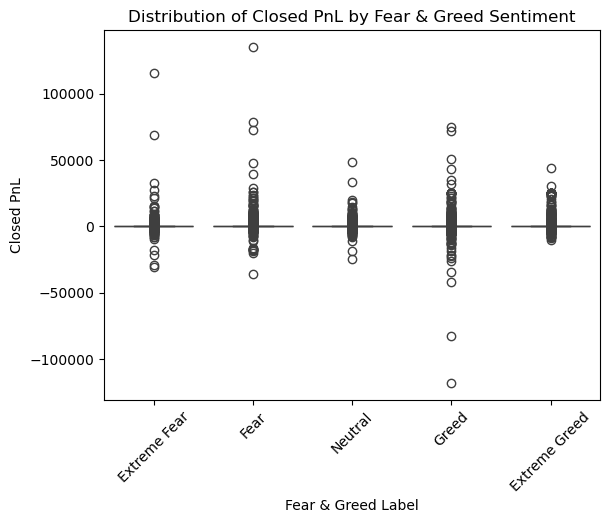

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=merged, x='fg_label', y='closed_pnl', order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'])
plt.title('Distribution of Closed PnL by Fear & Greed Sentiment')
plt.ylabel('Closed PnL')
plt.xlabel('Fear & Greed Label')
plt.xticks(rotation=45)
plt.show()

In [5]:
from scipy.stats import mannwhitneyu
import itertools

labels = merged['fg_label'].dropna().unique()
pairs = list(itertools.combinations(labels, 2))

results = []
for a, b in pairs:
    group_a = merged.loc[merged['fg_label']==a, 'closed_pnl']
    group_b = merged.loc[merged['fg_label']==b, 'closed_pnl']
    stat, p = mannwhitneyu(group_a, group_b, alternative='two-sided')
    results.append((a, b, p))

posthoc = pd.DataFrame(results, columns=['Group1','Group2','p_value']).sort_values('p_value')
posthoc.head(10)

,Group1,Group2,p_value
2,Extreme Greed,Greed,1.973073e-192
0,Extreme Greed,Extreme Fear,9.738490e-133
3,Extreme Greed,Neutral,1.268165e-131
7,Fear,Greed,1.304587e-68
1,Extreme Greed,Fear,2.599485e-56
4,Extreme Fear,Fear,2.844951e-50
8,Fear,Neutral,4.581313e-31
6,Extreme Fear,Neutral,6.194465e-08
9,Greed,Neutral,2.712807e-06
5,Extreme Fear,Greed,7.386990e-02


C:\Users\Apoorva GS\AppData\Local\Temp\ipykernel_14972\2254351090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


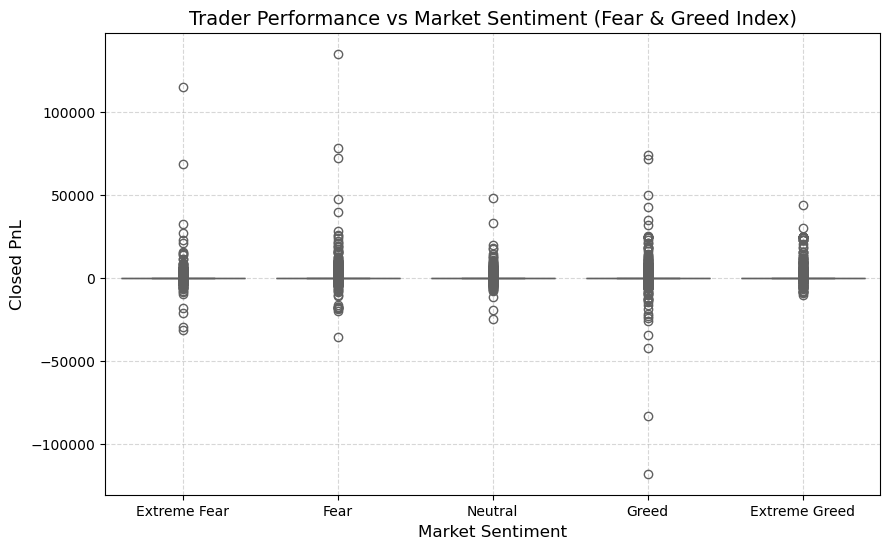

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=merged,
    x='fg_label',
    y='closed_pnl',
    order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'],
    palette='coolwarm'
)
plt.title('Trader Performance vs Market Sentiment (Fear & Greed Index)', fontsize=14)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Closed PnL', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


<Axes: xlabel='fg_label', ylabel='closed_pnl'>

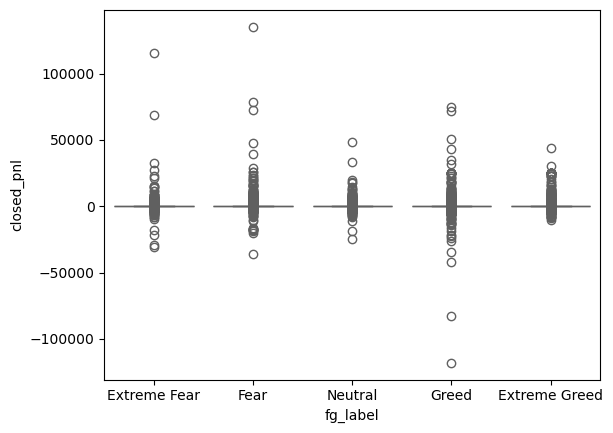

In [7]:
sns.boxplot(
    data=merged,
    x='fg_label',
    y='closed_pnl',
    order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'],
    hue='fg_label',
    palette='coolwarm',
    legend=False
)

In [18]:
import pandas as pd

historical = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Historical columns:\n", historical.columns.tolist())
print("\nSentiment columns:\n", sentiment.columns.tolist())


Historical columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns:
 ['timestamp', 'value', 'classification', 'date']


In [20]:
print(df.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'Date', 'timestamp', 'value', 'classification', 'date']
